# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


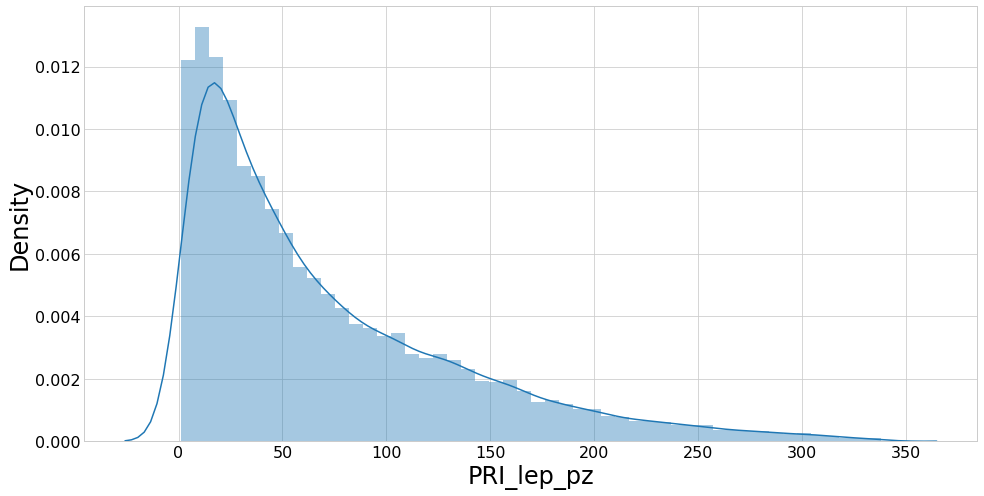

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


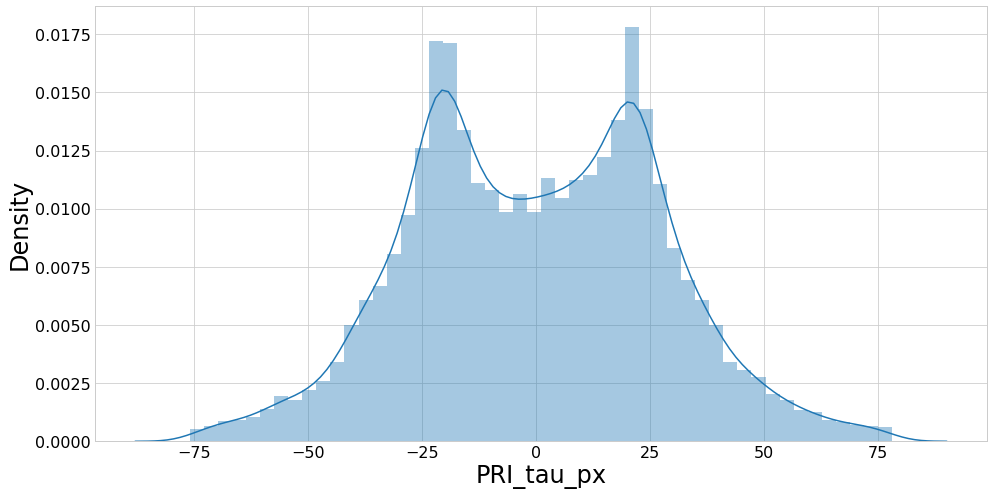

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


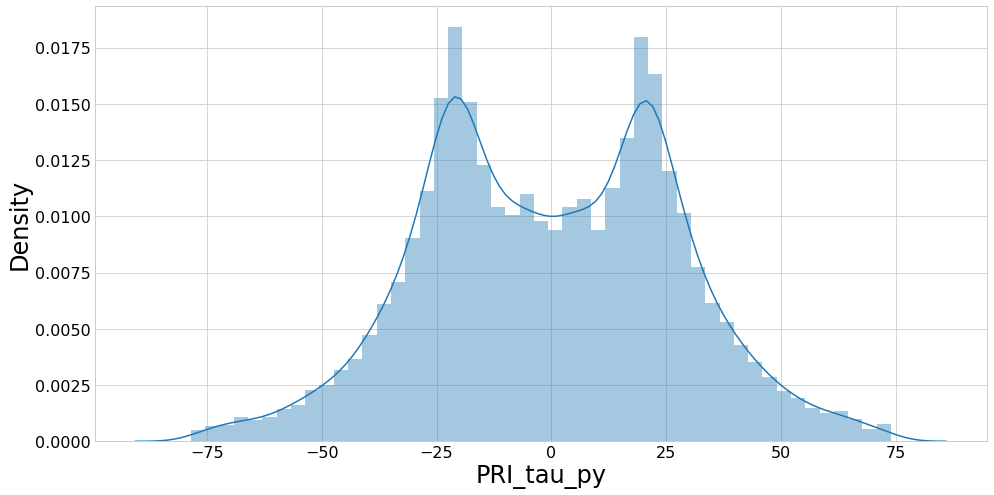

In [6]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')
plot_feat(data, 'PRI_tau_px')
plot_feat(data, 'PRI_tau_py')

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.617s 


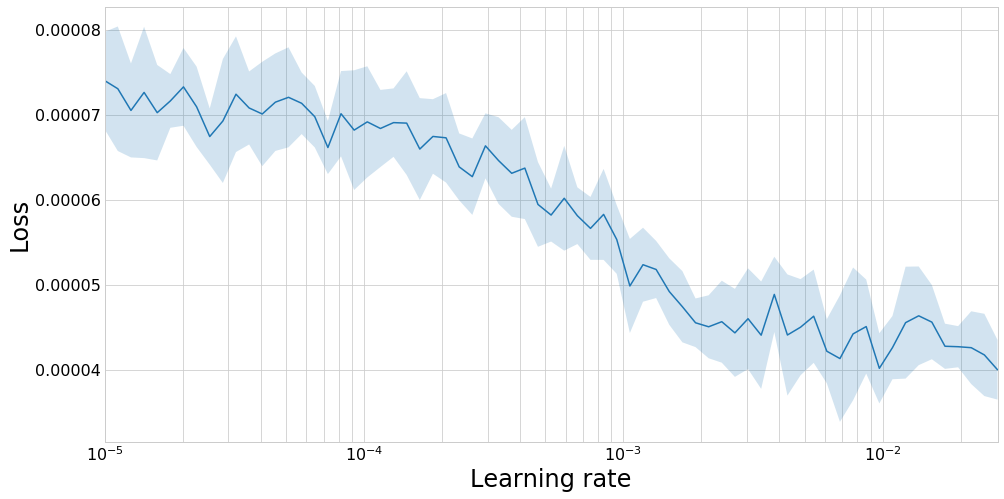

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 4.059727137791924e-05
2 New best found: 3.7759208149509505e-05
3 New best found: 3.665753457171377e-05
4 New best found: 3.628655856009573e-05
5 New best found: 3.554899244918488e-05
6 New best found: 3.533708986797137e-05
7 New best found: 3.521068896079669e-05
11 New best found: 3.4953328776464335e-05
12 New best found: 3.487663259584224e-05
13 New best found: 3.424724589567632e-05
14 New best found: 3.40247264932259e-05
22 New best found: 3.39740997806075e-05
23 New best found: 3.365901516081067e-05
27 New best found: 3.354171831306303e-05
28 New best found: 3.3537775213335406e-05
29 New best found: 3.348070480205934e-05
47 New best found: 3.3479705845093124e-05
49 New best found: 3.318988035680377e-05
53 New best found: 3.3097024183371104e-05
59 New best found: 3.303148113409406e-05
60 New best found: 3.300636431231396e-05
62 New best found: 3.3005909115

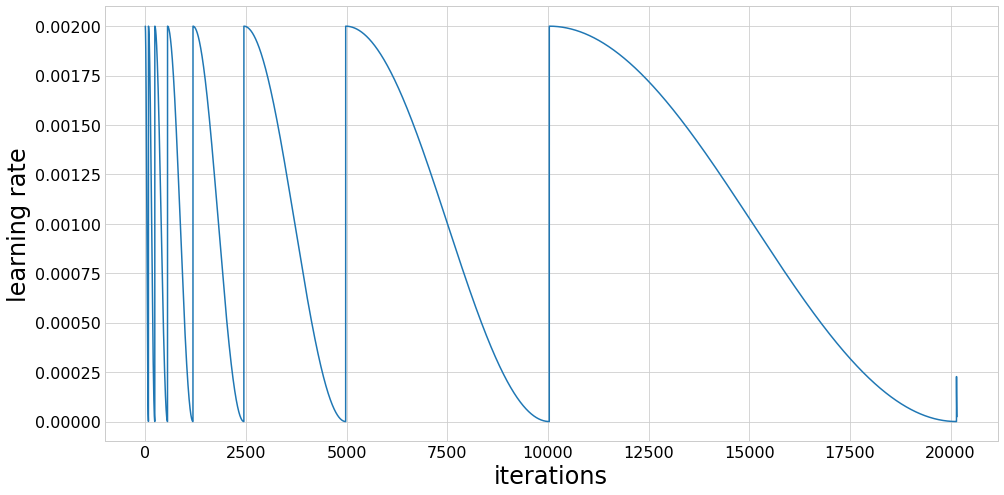

Fold took 227.092s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211604). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106136). Check your callbacks.
  % delta_t_median)


1 New best found: 4.008093174118137e-05
2 New best found: 3.704917073710135e-05
3 New best found: 3.6511178696742757e-05
4 New best found: 3.6435626742207584e-05
5 New best found: 3.5206805714472464e-05
6 New best found: 3.493755861336201e-05
7 New best found: 3.4701556582011286e-05
11 New best found: 3.44260098054328e-05
12 New best found: 3.4387571543664455e-05
13 New best found: 3.4301914705705435e-05
14 New best found: 3.397073992716988e-05
23 New best found: 3.370049775144887e-05
25 New best found: 3.3554932784353045e-05
27 New best found: 3.343909857702364e-05
28 New best found: 3.3351250231109135e-05
30 New best found: 3.330917164710343e-05
31 New best found: 3.330399078564006e-05
50 New best found: 3.3275870843723036e-05
53 New best found: 3.316836769517773e-05
54 New best found: 3.316508442676256e-05
55 New best found: 3.3041842538481166e-05
57 New best found: 3.303294340318514e-05
59 New best found: 3.300888669976968e-05
60 New best found: 3.2997638850047444e-05
61 New best f

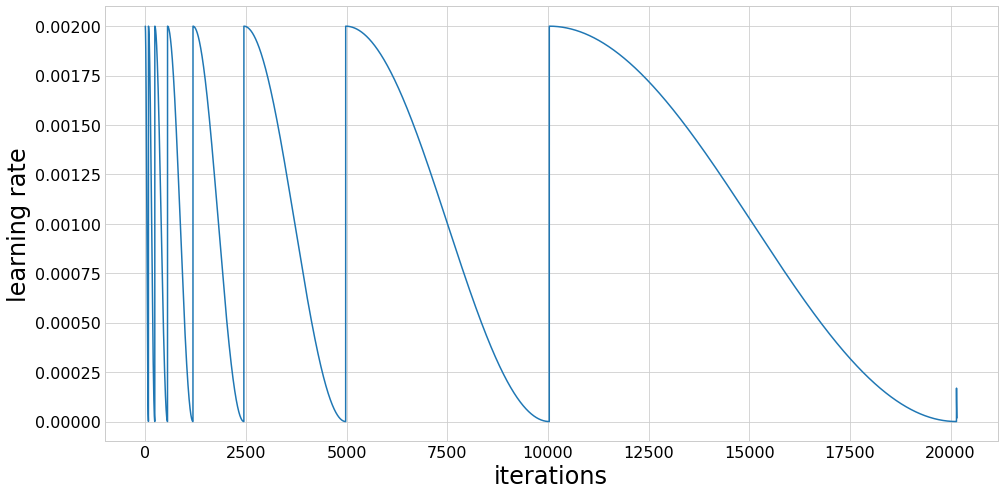

Fold took 233.180s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231803). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116250). Check your callbacks.
  % delta_t_median)


1 New best found: 3.863650239218259e-05
2 New best found: 3.686188224819489e-05
3 New best found: 3.5624220242607405e-05
4 New best found: 3.5604552419681566e-05
5 New best found: 3.463190409092931e-05
6 New best found: 3.42975590727292e-05
7 New best found: 3.4149876642914023e-05
10 New best found: 3.395647134748287e-05
11 New best found: 3.356979892851086e-05
12 New best found: 3.3309423227910884e-05
13 New best found: 3.329588073684135e-05
14 New best found: 3.3037668406905144e-05
15 New best found: 3.3015185268595815e-05
25 New best found: 3.2856292968790515e-05
26 New best found: 3.282549748691963e-05
27 New best found: 3.259007104643388e-05
28 New best found: 3.2528458241722546e-05
29 New best found: 3.240742276684614e-05
30 New best found: 3.238802968116943e-05
31 New best found: 3.2386413343192544e-05
50 New best found: 3.219764788664179e-05
52 New best found: 3.219006850558799e-05
55 New best found: 3.2181444352318066e-05
56 New best found: 3.207888499164255e-05
57 New best fo

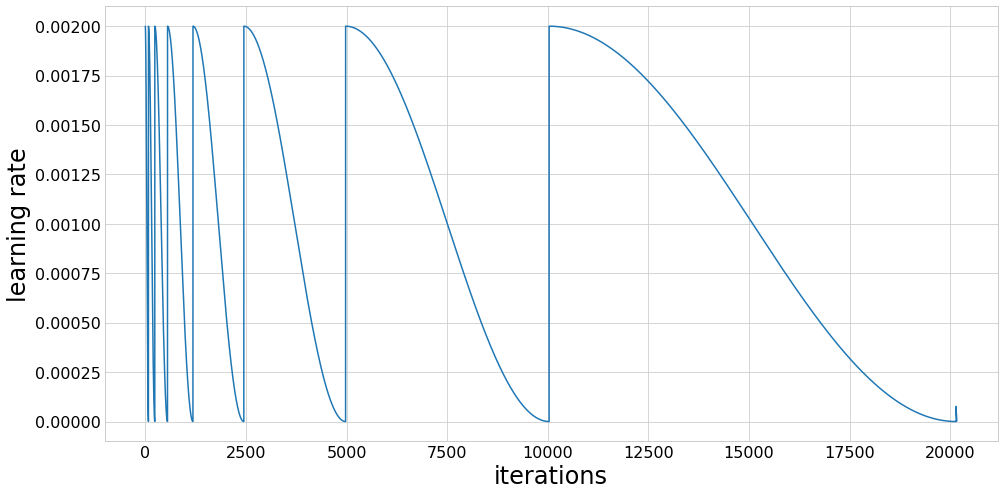

Fold took 242.252s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256728). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128698). Check your callbacks.
  % delta_t_median)


1 New best found: 3.833131818828406e-05
2 New best found: 3.570718257105909e-05
3 New best found: 3.4950055088847874e-05
5 New best found: 3.4330426059023014e-05
6 New best found: 3.34606817617896e-05
7 New best found: 3.338661384623265e-05
10 New best found: 3.324776565568754e-05
11 New best found: 3.302383582777111e-05
12 New best found: 3.2613540795136944e-05
13 New best found: 3.2471887866267935e-05
14 New best found: 3.229888677451527e-05
15 New best found: 3.227269269118551e-05
23 New best found: 3.213790392401279e-05
24 New best found: 3.1908375969214833e-05
26 New best found: 3.1841116618306844e-05
27 New best found: 3.172916592011461e-05
28 New best found: 3.168671697058016e-05
30 New best found: 3.166431845311308e-05
31 New best found: 3.164972234444576e-05
48 New best found: 3.161798671426368e-05
50 New best found: 3.1363537949800954e-05
53 New best found: 3.129995324270567e-05
54 New best found: 3.1271059173013785e-05
57 New best found: 3.121912360802526e-05
59 New best fou

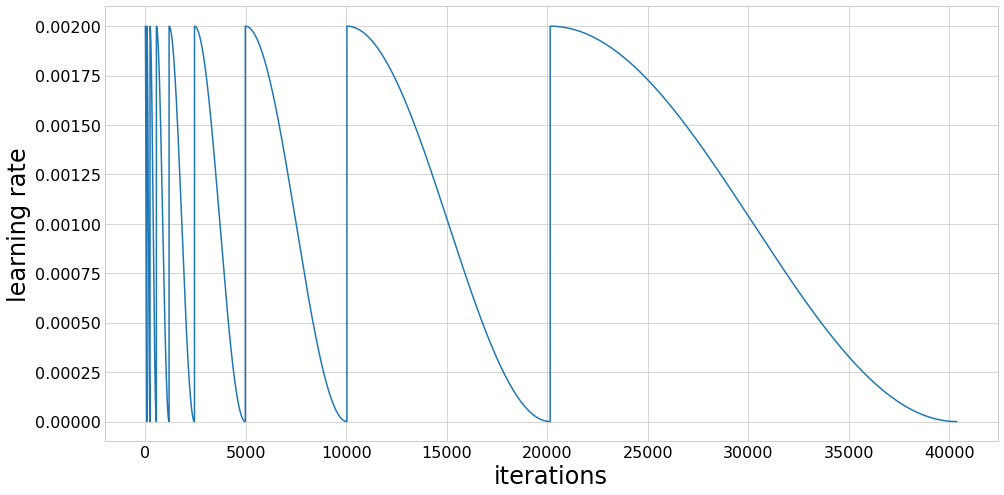

Fold took 467.001s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268727). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134691). Check your callbacks.
  % delta_t_median)


1 New best found: 3.997157537528867e-05
2 New best found: 3.625445976417407e-05
3 New best found: 3.540688240439491e-05
4 New best found: 3.4868246027329076e-05
5 New best found: 3.44534962499213e-05
6 New best found: 3.396704785852391e-05
7 New best found: 3.359841372098067e-05
9 New best found: 3.345624246462141e-05
11 New best found: 3.301396289066009e-05
12 New best found: 3.2524304005121894e-05
13 New best found: 3.2507779020555684e-05
15 New best found: 3.2478578866488655e-05
20 New best found: 3.2406550276671385e-05
22 New best found: 3.225940491027795e-05
24 New best found: 3.2162189143448904e-05
25 New best found: 3.206225859216216e-05
26 New best found: 3.202113204074461e-05
27 New best found: 3.1801232066416806e-05
29 New best found: 3.1762576189255554e-05
47 New best found: 3.1682741015349795e-05
48 New best found: 3.166976610309215e-05
51 New best found: 3.1576635922176026e-05
52 New best found: 3.1495959758013585e-05
54 New best found: 3.148622166987294e-05
56 New best fo

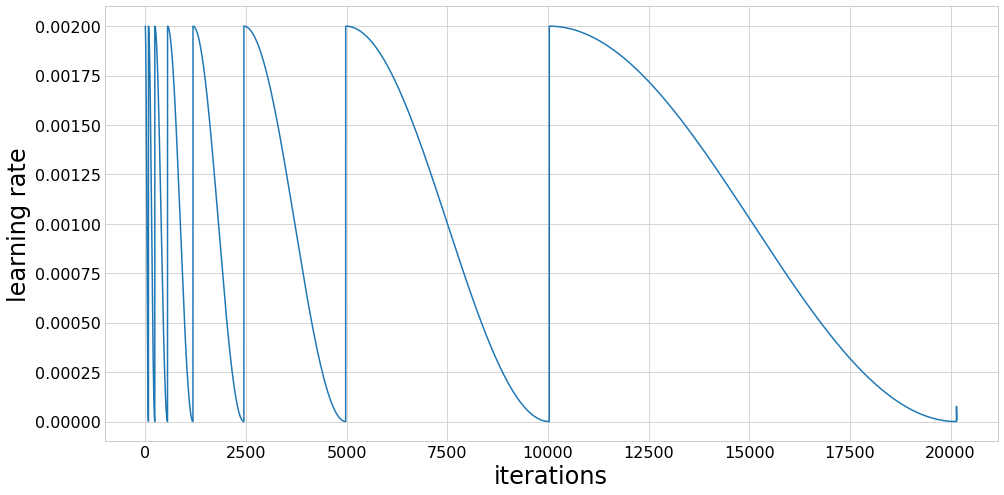

Fold took 241.728s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.339087). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169917). Check your callbacks.
  % delta_t_median)


1 New best found: 3.893767769074564e-05
2 New best found: 3.626199960736879e-05
3 New best found: 3.556810641742158e-05
4 New best found: 3.5366667366270346e-05
5 New best found: 3.4629927957915183e-05
6 New best found: 3.394330089613597e-05
7 New best found: 3.3808761163482814e-05
11 New best found: 3.353907232599373e-05
12 New best found: 3.335348857551779e-05
13 New best found: 3.325182375596634e-05
14 New best found: 3.301358122141335e-05
15 New best found: 3.2989361642135846e-05
25 New best found: 3.272451264316098e-05
26 New best found: 3.2721168116214276e-05
28 New best found: 3.2501962378526547e-05
29 New best found: 3.2464365670673184e-05
30 New best found: 3.244242930928789e-05
31 New best found: 3.243569650100916e-05
49 New best found: 3.239155738915502e-05
51 New best found: 3.222617441076561e-05
52 New best found: 3.2174521549021e-05
56 New best found: 3.2137805636147645e-05
58 New best found: 3.210686633532837e-05
60 New best found: 3.2097620843630535e-05
62 New best foun

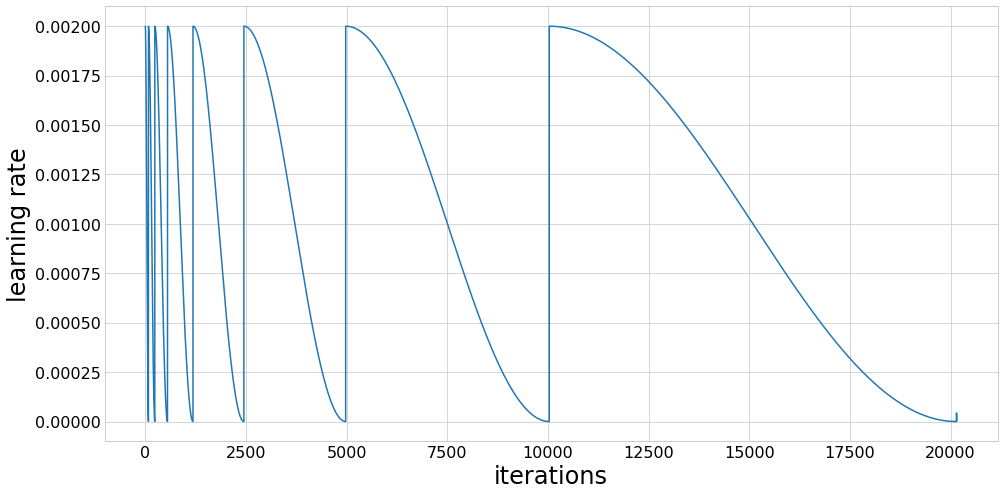

Fold took 245.750s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.381282). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191038). Check your callbacks.
  % delta_t_median)


1 New best found: 3.861750475662049e-05
2 New best found: 3.636770939871851e-05
3 New best found: 3.559877305316802e-05
5 New best found: 3.487419750091878e-05
6 New best found: 3.4604502921003585e-05
7 New best found: 3.440294876084216e-05
10 New best found: 3.415067302285206e-05
11 New best found: 3.4023952643400806e-05
12 New best found: 3.381410779812964e-05
13 New best found: 3.354699385687024e-05
14 New best found: 3.353489595632583e-05
15 New best found: 3.3457062409742625e-05
21 New best found: 3.333902152125421e-05
23 New best found: 3.332710057424145e-05
25 New best found: 3.310285392322834e-05
26 New best found: 3.28802439043757e-05
28 New best found: 3.282353131366021e-05
29 New best found: 3.273193039021857e-05
47 New best found: 3.2711893543796326e-05
50 New best found: 3.250502370336685e-05
53 New best found: 3.2400667385591616e-05
56 New best found: 3.230464944757562e-05
58 New best found: 3.226278119806481e-05
59 New best found: 3.224131405830454e-05
107 New best found

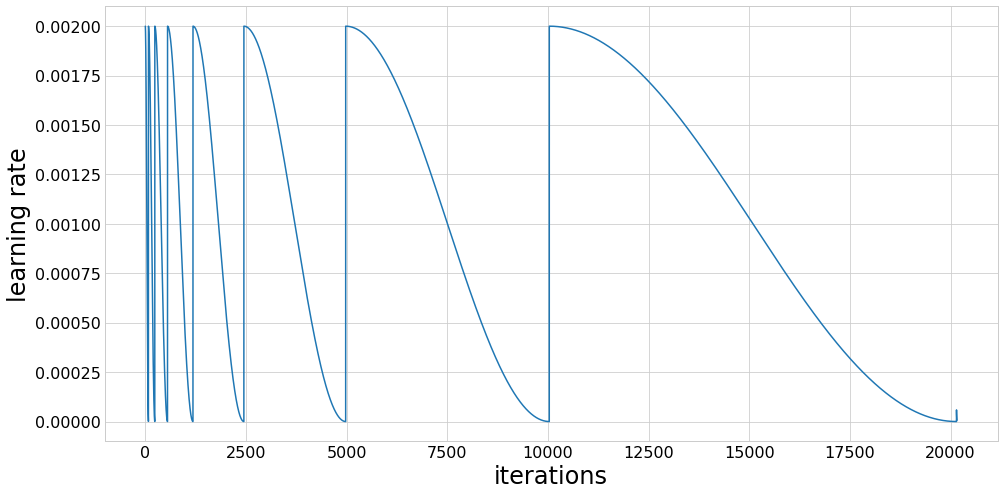

Fold took 249.737s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.347584). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174183). Check your callbacks.
  % delta_t_median)


1 New best found: 3.882637435008575e-05
2 New best found: 3.667991246285322e-05
3 New best found: 3.5832213206007006e-05
4 New best found: 3.565841596750872e-05
5 New best found: 3.5136430344197015e-05
6 New best found: 3.46626832356045e-05
7 New best found: 3.457403573048872e-05
10 New best found: 3.442260428763223e-05
11 New best found: 3.413275922810769e-05
12 New best found: 3.401942606908657e-05
13 New best found: 3.394167941256366e-05
14 New best found: 3.370658562138594e-05
15 New best found: 3.3687127428143576e-05
23 New best found: 3.349796314196198e-05
25 New best found: 3.3217861012346155e-05
26 New best found: 3.308902921282294e-05
29 New best found: 3.296215564411829e-05
30 New best found: 3.29263421645951e-05
52 New best found: 3.2898999926281304e-05
53 New best found: 3.2772959740682906e-05
56 New best found: 3.270227571958496e-05
57 New best found: 3.2673695959266735e-05
58 New best found: 3.264522038095493e-05
59 New best found: 3.26001413082138e-05
61 New best found: 

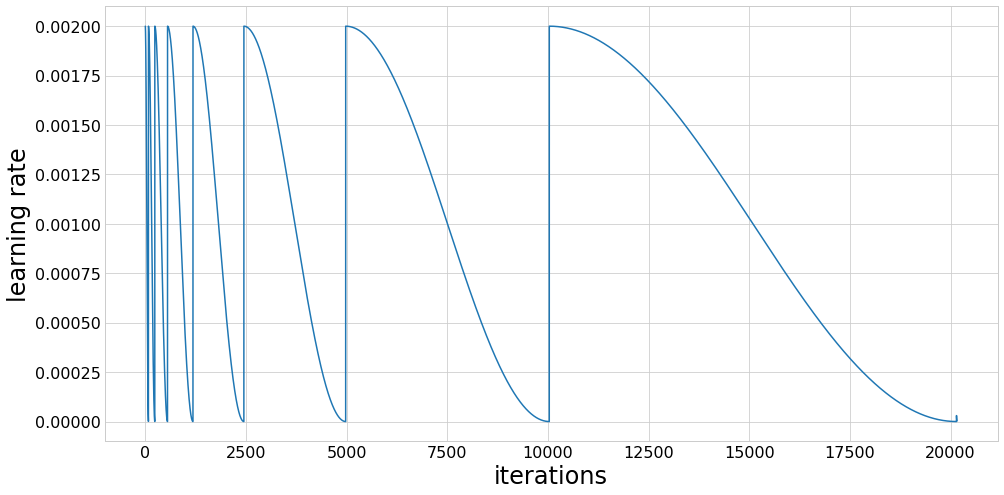

Fold took 252.157s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.411860). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206322). Check your callbacks.
  % delta_t_median)


1 New best found: 3.901786013810066e-05
2 New best found: 3.670684397039784e-05
3 New best found: 3.6037585192254674e-05
5 New best found: 3.550643033863625e-05
6 New best found: 3.4973027202701455e-05
7 New best found: 3.483916138279518e-05
11 New best found: 3.418272516847574e-05
13 New best found: 3.383108918015142e-05
14 New best found: 3.371025764553194e-05
15 New best found: 3.3703460583237415e-05
22 New best found: 3.3362358309891906e-05
25 New best found: 3.319795243675241e-05
27 New best found: 3.306526681775078e-05
28 New best found: 3.302368309179877e-05
29 New best found: 3.294584074424232e-05
31 New best found: 3.294433143685255e-05
50 New best found: 3.282073011430872e-05
54 New best found: 3.264223077265837e-05
56 New best found: 3.262354846120286e-05
58 New best found: 3.2582882963484514e-05
59 New best found: 3.255109904599076e-05
104 New best found: 3.254272350910024e-05
107 New best found: 3.2524750200398746e-05
108 New best found: 3.24732711500373e-05
109 New best f

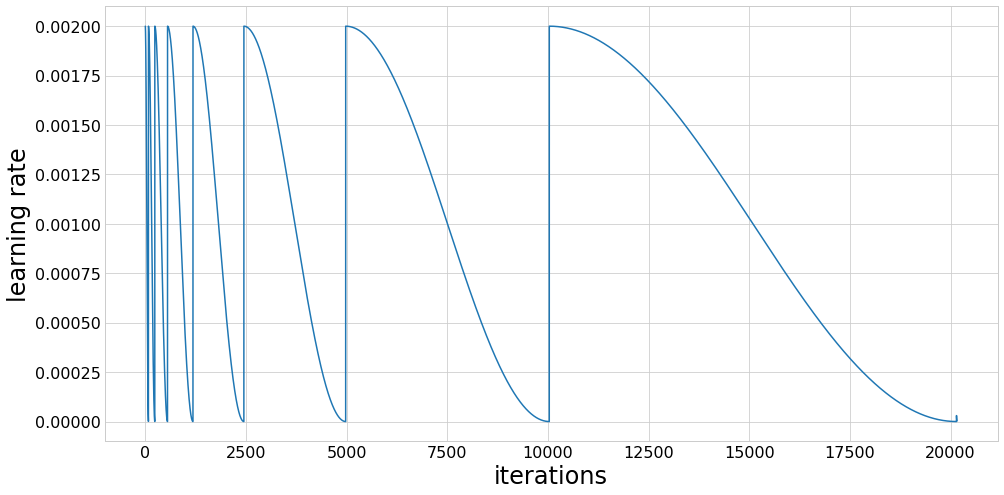

Fold took 259.909s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.449312). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225295). Check your callbacks.
  % delta_t_median)


1 New best found: 3.727596574317431e-05
2 New best found: 3.533030974213034e-05
3 New best found: 3.473315523442579e-05
4 New best found: 3.4442735629272646e-05
5 New best found: 3.377901416242821e-05
6 New best found: 3.358832976227859e-05
7 New best found: 3.3386833060649227e-05
10 New best found: 3.313120965613052e-05
11 New best found: 3.3083167084259915e-05
12 New best found: 3.2836573614622464e-05
13 New best found: 3.2622371098841544e-05
14 New best found: 3.247911848011427e-05
21 New best found: 3.245998907805188e-05
23 New best found: 3.240012099267915e-05
25 New best found: 3.2319153219577854e-05
26 New best found: 3.228127105976455e-05
27 New best found: 3.211537856695941e-05
28 New best found: 3.1923220450698866e-05
50 New best found: 3.1791517039528116e-05
52 New best found: 3.174729556922102e-05
53 New best found: 3.160176021629013e-05
54 New best found: 3.15785103928647e-05
55 New best found: 3.154120299659553e-05
56 New best found: 3.150551120197633e-05
59 New best foun

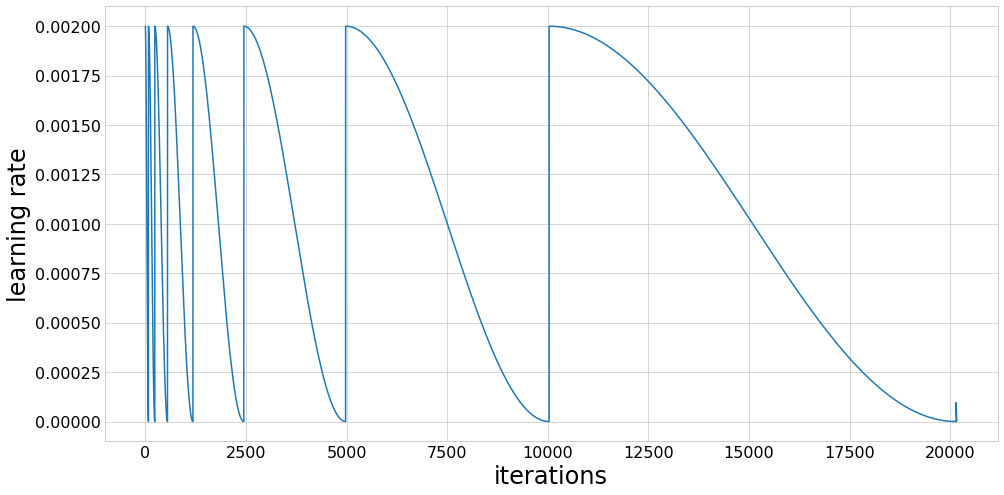

Fold took 269.293s


______________________________________
Training finished
Cross-validation took 2690.896s 


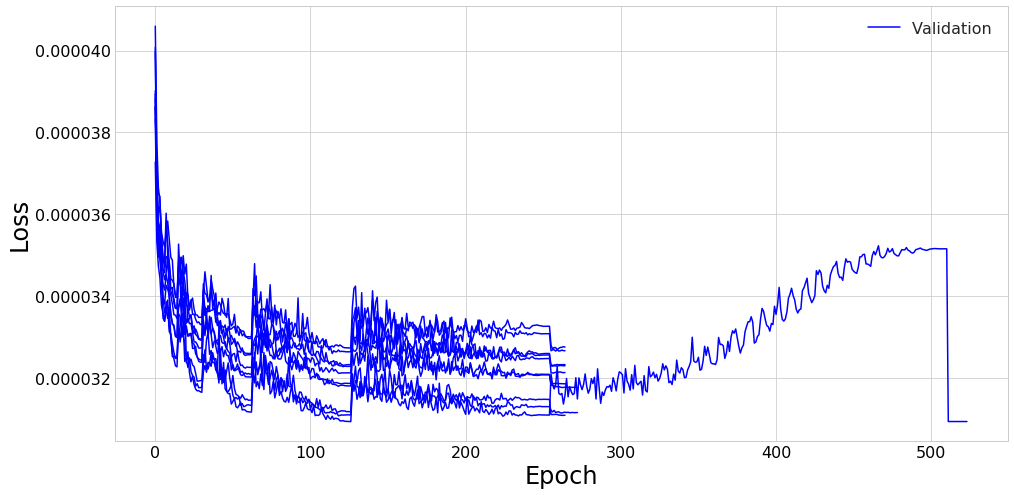

Mean loss = 3.19e-05 +- 2e-07
Mean wAUC = 0.0637 +- 0.0008
Mean AUC = 0.0989 +- 0.0008
Mean AMS = 3.93 +- 0.06
Mean cut = 0.969 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 3 with loss = 3.093644778709859e-05
Model 1 is 4 with loss = 3.1077591409161065e-05
Model 2 is 9 with loss = 3.1145568396459566e-05
Model 3 is 2 with loss = 3.1767914271040355e-05
Model 4 is 5 with loss = 3.185462661542088e-05
Model 5 is 6 with loss = 3.211634215346854e-05
Model 6 is 7 with loss = 3.227760753346955e-05
Model 7 is 8 with loss = 3.231019330095341e-05
Model 8 is 1 with loss = 3.259858266322623e-05
Model 9 is 0 with loss = 3.268405272756354e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017918087175115944s per sample

Predicting fold 2 out of 10
Prediction took 0.0003213956966996193s per sample

Predicting fold 3 out of 10
Prediction took 0.0003208711063489318s per sample

Predicting fold 4 out of 10
Prediction took 0.0003246568216010928s per sample

Predicting fold 5 out of 10
Prediction took 0.0003189189858734608s per sample

Predicting fold 6 out of 10
Prediction took 0.00032229891438037155s per sample

Predicting fold 7 out of 10
Prediction took 0.00032003204300999643s per sample

Predicting fold 8 out of 10
Prediction took 0.00032089032791554926s per sample

Predicting fold 9 out of 10
Prediction took 0.00032199032492935656s per sample

Predicting fold 10 out of 10
Prediction took 0.00031807788908481597s per sample



In [14]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9030655648657318, weighted 0.9356171005494431


In [15]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.907975686331742, 0.96318245)

In [16]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9632798481034115, corresponds to calc_ams of 3.9135422392266923
CPU times: user 2.57 s, sys: 13.7 s, total: 16.3 s
Wall time: 2min 6s


(4.0, 0.96)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [17]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005581448905728758s per sample

Predicting fold 2 out of 10
Prediction took 0.005596599841117859s per sample

Predicting fold 3 out of 10
Prediction took 0.005605705565586686s per sample

Predicting fold 4 out of 10
Prediction took 0.005597683120332658s per sample

Predicting fold 5 out of 10
Prediction took 0.005582190491631627s per sample

Predicting fold 6 out of 10
Prediction took 0.005629387078247964s per sample

Predicting fold 7 out of 10
Prediction took 0.005594579009152949s per sample

Predicting fold 8 out of 10
Prediction took 0.005578514354117214s per sample

Predicting fold 9 out of 10
Prediction took 0.0055624260526150465s per sample

Predicting fold 10 out of 10
Prediction took 0.005627235386893153s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9031348132245158, weighted 0.9356449333766059


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.891004277706353, 0.95381534)

In [21]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9600633052177727, corresponds to calc_ams of 3.815496425527477
CPU times: user 2.37 s, sys: 15.4 s, total: 17.8 s
Wall time: 2min 7s


(4.0, 0.96)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003341142228719863s per sample

Predicting fold 2 out of 10
Prediction took 0.0003335664058950814s per sample

Predicting fold 3 out of 10
Prediction took 0.00033281099185008894s per sample

Predicting fold 4 out of 10
Prediction took 0.0003356118267571384s per sample

Predicting fold 5 out of 10
Prediction took 0.0003379657039588148s per sample

Predicting fold 6 out of 10
Prediction took 0.00033601590283215046s per sample

Predicting fold 7 out of 10
Prediction took 0.00033415410726923833s per sample

Predicting fold 8 out of 10
Prediction took 0.0003332617907869545s per sample

Predicting fold 9 out of 10
Prediction took 0.0003336058212274855s per sample

Predicting fold 10 out of 10
Prediction took 0.0003345822279595516s per sample

CPU times: user 3min 18s, sys: 11.7 s, total: 3min 30s
Wall time: 3min 4s


In [24]:
score_test_data(test_fy.source, 0.9632798481034115)

Public:Private AMS: 3.6341661154235596 : 3.740041525034762


(3.6341661154235596, 3.740041525034762)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [26]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005454294398020614s per sample

Predicting fold 2 out of 10
Prediction took 0.005443163371052254s per sample

Predicting fold 3 out of 10
Prediction took 0.005446926728940823s per sample

Predicting fold 4 out of 10
Prediction took 0.005441959951750256s per sample

Predicting fold 5 out of 10
Prediction took 0.005444797190075571s per sample

Predicting fold 6 out of 10
Prediction took 0.005448836232620206s per sample

Predicting fold 7 out of 10
Prediction took 0.005452876458232375s per sample

Predicting fold 8 out of 10
Prediction took 0.005438990415632725s per sample

Predicting fold 9 out of 10
Prediction took 0.00544443848898465s per sample

Predicting fold 10 out of 10
Prediction took 0.005449244419062002s per sample

CPU times: user 53min 43s, sys: 3min 14s, total: 56min 57s
Wall time: 49min 55s


In [27]:
score_test_data(test_fy.source, 0.9600633052177727)

Public:Private AMS: 3.6849254861067138 : 3.7652860434527544


(3.6849254861067138, 3.7652860434527544)

In [ ]:
score_test_data(test_fy.source, 0.9538)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)